In [1]:
!pip install timm torch torchvision

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import os
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
import torch
import torchvision
from torchvision import datasets
from torchvision import transforms as T
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split
from torchvision import models
import warnings
import sys
from tqdm import tqdm
import time
import copy
import timm
from timm.loss.binary_cross_entropy import BinaryCrossEntropy
warnings.filterwarnings("ignore")

In [3]:
def get_data_loaders(batch_size, train=False):
    if train:
        # Image augmentation for train data
        transform = T.Compose([
            T.RandomHorizontalFlip(p=0.5),
            T.ColorJitter(brightness=0.05, contrast=0.05),
            T.Resize(224),
            T.CenterCrop(224),
            T.ToTensor(),
            T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),  # ImageNet mean and stdev
            T.RandomErasing(p=0.05, value='random')
        ])
        
        train_data_path = '/kaggle/input/cropped-and-balanced-openforensics-data/train_cropped_faces_224_rgb_balanced/Train'
        train_data = datasets.ImageFolder(train_data_path, transform = transform)
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)
        return train_loader, train_data
    else:
        # No image augmentation for val and test data
        transform = T.Compose([
            T.Resize(224),
            T.CenterCrop(224),
            T.ToTensor(),
            T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), # ImageNet mean and stdev
        ])
        
        val_data_path = '/kaggle/input/cropped-and-balanced-openforensics-data/val_cropped_faces_224_rgb/Val'
        test_data_path = '/kaggle/input/cropped-and-balanced-openforensics-data/test_cropped_faces_224_rgb/Test'
        
        val_data = datasets.ImageFolder(val_data_path, transform=transform)
        test_data = datasets.ImageFolder(test_data_path, transform=transform)
        
        val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True, num_workers=4)
        test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=4)
        return val_loader, test_loader, val_data, test_data

In [4]:
(train_loader, train_data) = get_data_loaders(batch_size=128, train=True)
(val_loader, test_loader, val_data, test_data) = get_data_loaders(batch_size=32, train=False)

In [5]:
print(train_data.class_to_idx)
print(val_data.class_to_idx)
print(test_data.class_to_idx)

{'Fake': 0, 'Real': 1}
{'Fake': 0, 'Real': 1}
{'Fake': 0, 'Real': 1}


In [6]:
dataloaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}
dataset_sizes = {
    'train': len(train_data),
    'val': len(val_data),
    'test': len(test_data)
}

In [7]:
print('Train, val, and test data size:')
dataset_sizes['train'], dataset_sizes['val'], dataset_sizes['test']

Train, val, and test data size:


(131720, 15345, 49718)

In [8]:
classes = ['Fake', 'Real']

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [10]:
timm.models.list_models('xcit*')

['xcit_large_24_p8_224',
 'xcit_large_24_p8_384',
 'xcit_large_24_p16_224',
 'xcit_large_24_p16_384',
 'xcit_medium_24_p8_224',
 'xcit_medium_24_p8_384',
 'xcit_medium_24_p16_224',
 'xcit_medium_24_p16_384',
 'xcit_nano_12_p8_224',
 'xcit_nano_12_p8_384',
 'xcit_nano_12_p16_224',
 'xcit_nano_12_p16_384',
 'xcit_small_12_p8_224',
 'xcit_small_12_p8_384',
 'xcit_small_12_p16_224',
 'xcit_small_12_p16_384',
 'xcit_small_24_p8_224',
 'xcit_small_24_p8_384',
 'xcit_small_24_p16_224',
 'xcit_small_24_p16_384',
 'xcit_tiny_12_p8_224',
 'xcit_tiny_12_p8_384',
 'xcit_tiny_12_p16_224',
 'xcit_tiny_12_p16_384',
 'xcit_tiny_24_p8_224',
 'xcit_tiny_24_p8_384',
 'xcit_tiny_24_p16_224',
 'xcit_tiny_24_p16_384']

# AdamW

In [11]:
xcit_model = timm.create_model('xcit_tiny_12_p16_224', pretrained=True, num_classes=2)

model.safetensors:   0%|          | 0.00/26.9M [00:00<?, ?B/s]

In [12]:
for param in xcit_model.parameters(): #freeze model
    param.requires_grad = False

n_inputs = xcit_model.head.in_features
xcit_model.head = nn.Sequential(
    nn.Linear(n_inputs, 32),
    nn.ReLU(),
    nn.Linear(32, 64),
    nn.ReLU(),
    nn.Linear(64, 1),
)

xcit_model = xcit_model.to(device)
xcit_model

Xcit(
  (patch_embed): ConvPatchEmbed(
    (proj): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): GELU(approximate='none')
      (2): Sequential(
        (0): Conv2d(24, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (3): GELU(approximate='none')
      (4): Sequential(
        (0): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (5): GELU(approximate='none')
      (6): Sequential(
        (0): Conv2d(96, 192, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, tr

In [13]:
def calculate_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total parameters: {total_params:,}")
    
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Trainable parameters: {trainable_params:,}")

In [14]:
calculate_parameters(xcit_model)

Total parameters: 6,531,625
Trainable parameters: 8,353


In [15]:
criterion = BinaryCrossEntropy()
criterion = criterion.to(device)
optimizer = optim.AdamW(xcit_model.head.parameters(), lr=0.001)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.97)

In [16]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=5):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(1, num_epochs + 1):
        print(f'\nEpoch {epoch}/{num_epochs}')
        print("=" * 20)

        epoch_stats = {
            'train': {'loss': 0, 'acc': 0, 'precision': 0, 'recall': 0, 'f1': 0},
            'val': {'loss': 0, 'acc': 0, 'precision': 0, 'recall': 0, 'f1': 0}
        }
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0.0
            
            all_preds = []
            all_labels = []
            
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    outputs = outputs.squeeze(1)  # Flatten output to [batch_size]
                    preds = (torch.sigmoid(outputs) > 0.5).float()  # Predictions
                    loss = criterion(outputs, labels.float())  # Compute loss
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data.float())  # Compare predictions

                all_preds.extend(preds.cpu().numpy())  # Store all predictions
                all_labels.extend(labels.cpu().numpy())  # Store all labels

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            # Calculate precision, recall, and F1 score
            precision = precision_score(all_labels, all_preds, zero_division=0)
            recall = recall_score(all_labels, all_preds, zero_division=0)
            f1 = f1_score(all_labels, all_preds, zero_division=0)
            
            # Update epoch stats
            epoch_stats[phase]['loss'] = epoch_loss
            epoch_stats[phase]['acc'] = epoch_acc.item()
            epoch_stats[phase]['precision'] = precision
            epoch_stats[phase]['recall'] = recall
            epoch_stats[phase]['f1'] = f1
            
            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} "
                  f"Precision: {precision:.4f} Recall: {recall:.4f} F1: {f1:.4f}")
            
            # Save the best model based on F1 score or other metrics (optional)
            if phase == 'val' and f1 > best_acc:
                best_acc = f1
                best_model_wts = copy.deepcopy(model.state_dict())
        
        print('-' * 20)
    
    time_elapsed = time.time() - since
    print('Training completed in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print("Best Val F1: {:.4f}".format(best_acc))
    
    model.load_state_dict(best_model_wts)
    return model

In [17]:
xcit_model_history = train_model(xcit_model, criterion, optimizer, exp_lr_scheduler)


Epoch 1/5


100%|██████████| 1030/1030 [05:27<00:00,  3.15it/s]


train Loss: 0.2650 Acc: 0.8866 Precision: 0.8855 Recall: 0.8880 F1: 0.8867


100%|██████████| 480/480 [00:31<00:00, 15.34it/s]


val Loss: 0.2728 Acc: 0.8873 Precision: 0.8326 Recall: 0.7990 F1: 0.8155
--------------------

Epoch 2/5


100%|██████████| 1030/1030 [04:03<00:00,  4.24it/s]


train Loss: 0.2084 Acc: 0.9131 Precision: 0.9100 Recall: 0.9169 F1: 0.9135


100%|██████████| 480/480 [00:23<00:00, 20.28it/s]


val Loss: 0.2617 Acc: 0.8921 Precision: 0.8478 Recall: 0.7969 F1: 0.8216
--------------------

Epoch 3/5


100%|██████████| 1030/1030 [03:58<00:00,  4.32it/s]


train Loss: 0.1964 Acc: 0.9182 Precision: 0.9145 Recall: 0.9227 F1: 0.9186


100%|██████████| 480/480 [00:23<00:00, 20.70it/s]


val Loss: 0.2551 Acc: 0.8969 Precision: 0.8625 Recall: 0.7961 F1: 0.8280
--------------------

Epoch 4/5


100%|██████████| 1030/1030 [04:00<00:00,  4.28it/s]


train Loss: 0.1889 Acc: 0.9209 Precision: 0.9172 Recall: 0.9253 F1: 0.9212


100%|██████████| 480/480 [00:22<00:00, 20.89it/s]


val Loss: 0.2445 Acc: 0.8994 Precision: 0.8783 Recall: 0.7863 F1: 0.8297
--------------------

Epoch 5/5


100%|██████████| 1030/1030 [03:57<00:00,  4.33it/s]


train Loss: 0.1813 Acc: 0.9251 Precision: 0.9221 Recall: 0.9286 F1: 0.9253


100%|██████████| 480/480 [00:23<00:00, 20.64it/s]


val Loss: 0.2411 Acc: 0.8976 Precision: 0.8413 Recall: 0.8273 F1: 0.8342
--------------------
Training completed in 23m 33s
Best Val F1: 0.8342


In [18]:
all_preds = []
all_targets = []

# Switch model to evaluation mode
xcit_model.eval()

# Loop over test data
for inputs, labels in tqdm(test_loader):
    inputs, labels = inputs.to(device), labels.to(device)
    with torch.no_grad():
        outputs = xcit_model(inputs)
        outputs = outputs.squeeze(1)  # Ensure outputs are [batch_size]
        preds = (torch.sigmoid(outputs) > 0.5).float()  # Threshold predictions (binary)
    
    # Store predictions and targets
    all_preds.extend(preds.cpu().numpy())
    all_targets.extend(labels.cpu().numpy())

# Convert predictions and targets to numpy arrays
all_preds = np.array(all_preds)
all_targets = np.array(all_targets)

100%|██████████| 1554/1554 [01:45<00:00, 14.74it/s]


In [19]:
print("Classification Report:")
print(classification_report(all_targets, all_preds, target_names=classes))

Classification Report:
              precision    recall  f1-score   support

        Fake       0.93      0.93      0.93     28670
        Real       0.91      0.90      0.90     21048

    accuracy                           0.92     49718
   macro avg       0.92      0.92      0.92     49718
weighted avg       0.92      0.92      0.92     49718



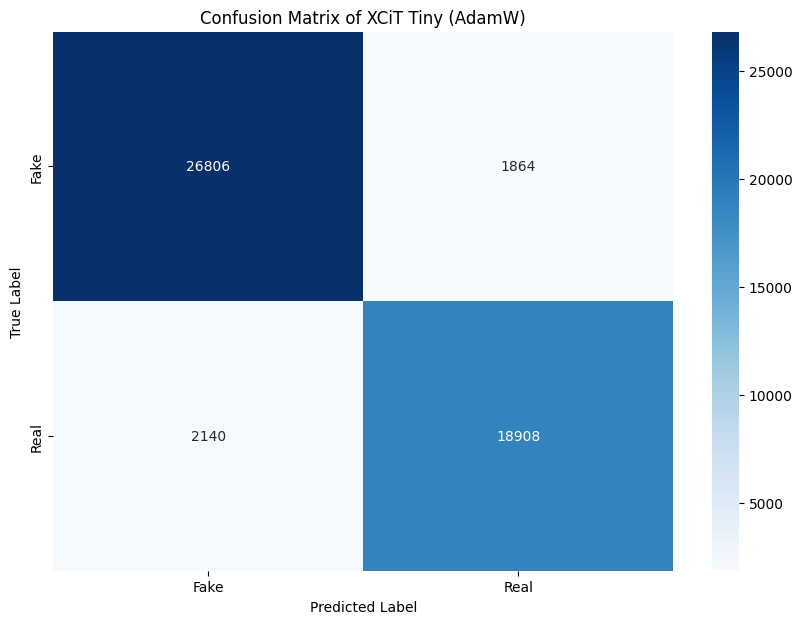

In [20]:
cm = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix of XCiT Tiny (AdamW)')
plt.show()

In [22]:
torch.save(xcit_model.state_dict(), 'xcit_tiny_patch16_224_5_epochs_balanced_adamw.pth')

# Adamax

In [23]:
xcit_model = timm.create_model('xcit_tiny_12_p16_224', pretrained=True, num_classes=2)

In [24]:
for param in xcit_model.parameters(): #freeze model
    param.requires_grad = False

n_inputs = xcit_model.head.in_features
xcit_model.head = nn.Sequential(
    nn.Linear(n_inputs, 32),
    nn.ReLU(),
    nn.Linear(32, 64),
    nn.ReLU(),
    nn.Linear(64, 1),
)

xcit_model = xcit_model.to(device)
xcit_model

Xcit(
  (patch_embed): ConvPatchEmbed(
    (proj): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): GELU(approximate='none')
      (2): Sequential(
        (0): Conv2d(24, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (3): GELU(approximate='none')
      (4): Sequential(
        (0): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (5): GELU(approximate='none')
      (6): Sequential(
        (0): Conv2d(96, 192, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, tr

In [25]:
calculate_parameters(xcit_model)

Total parameters: 6,531,625
Trainable parameters: 8,353


In [26]:
criterion = BinaryCrossEntropy()
criterion = criterion.to(device)
optimizer = optim.Adamax(xcit_model.head.parameters(), lr=0.001)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.97)

In [27]:
xcit_model_history = train_model(xcit_model, criterion, optimizer, exp_lr_scheduler)


Epoch 1/5


100%|██████████| 1030/1030 [04:02<00:00,  4.25it/s]


train Loss: 0.3040 Acc: 0.8675 Precision: 0.8703 Recall: 0.8637 F1: 0.8670


100%|██████████| 480/480 [00:22<00:00, 20.90it/s]


val Loss: 0.3187 Acc: 0.8633 Precision: 0.8335 Recall: 0.7016 F1: 0.7619
--------------------

Epoch 2/5


100%|██████████| 1030/1030 [04:01<00:00,  4.27it/s]


train Loss: 0.2423 Acc: 0.8977 Precision: 0.8986 Recall: 0.8967 F1: 0.8976


100%|██████████| 480/480 [00:23<00:00, 20.69it/s]


val Loss: 0.2985 Acc: 0.8717 Precision: 0.8564 Recall: 0.7070 F1: 0.7746
--------------------

Epoch 3/5


100%|██████████| 1030/1030 [03:58<00:00,  4.32it/s]


train Loss: 0.2228 Acc: 0.9062 Precision: 0.9059 Recall: 0.9065 F1: 0.9062


100%|██████████| 480/480 [00:23<00:00, 20.71it/s]


val Loss: 0.2752 Acc: 0.8833 Precision: 0.8389 Recall: 0.7742 F1: 0.8052
--------------------

Epoch 4/5


100%|██████████| 1030/1030 [04:00<00:00,  4.27it/s]


train Loss: 0.2103 Acc: 0.9127 Precision: 0.9124 Recall: 0.9131 F1: 0.9128


100%|██████████| 480/480 [00:23<00:00, 20.57it/s]


val Loss: 0.2780 Acc: 0.8844 Precision: 0.8292 Recall: 0.7921 F1: 0.8103
--------------------

Epoch 5/5


100%|██████████| 1030/1030 [04:01<00:00,  4.27it/s]


train Loss: 0.2002 Acc: 0.9162 Precision: 0.9152 Recall: 0.9174 F1: 0.9163


100%|██████████| 480/480 [00:23<00:00, 20.69it/s]


val Loss: 0.2566 Acc: 0.8932 Precision: 0.8386 Recall: 0.8139 F1: 0.8261
--------------------
Training completed in 22m 2s
Best Val F1: 0.8261


In [28]:
all_preds = []
all_targets = []

# Switch model to evaluation mode
xcit_model.eval()

# Loop over test data
for inputs, labels in tqdm(test_loader):
    inputs, labels = inputs.to(device), labels.to(device)
    with torch.no_grad():
        outputs = xcit_model(inputs)
        outputs = outputs.squeeze(1)  # Ensure outputs are [batch_size]
        preds = (torch.sigmoid(outputs) > 0.5).float()  # Threshold predictions (binary)
    
    # Store predictions and targets
    all_preds.extend(preds.cpu().numpy())
    all_targets.extend(labels.cpu().numpy())

# Convert predictions and targets to numpy arrays
all_preds = np.array(all_preds)
all_targets = np.array(all_targets)

100%|██████████| 1554/1554 [01:15<00:00, 20.68it/s]


In [29]:
print("Classification Report:")
print(classification_report(all_targets, all_preds, target_names=classes))

Classification Report:
              precision    recall  f1-score   support

        Fake       0.92      0.93      0.92     28670
        Real       0.90      0.89      0.89     21048

    accuracy                           0.91     49718
   macro avg       0.91      0.91      0.91     49718
weighted avg       0.91      0.91      0.91     49718



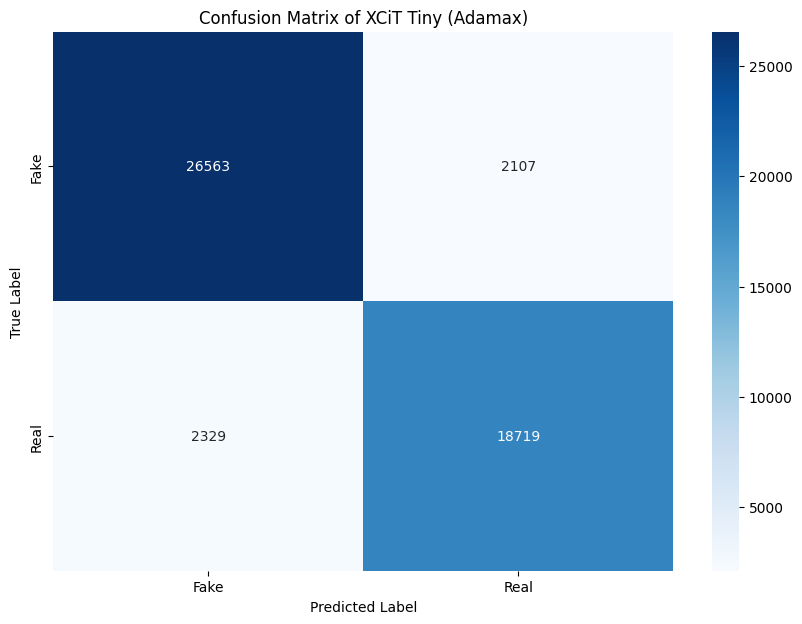

In [30]:
cm = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix of XCiT Tiny (Adamax)')
plt.show()

In [31]:
torch.save(xcit_model.state_dict(), 'xcit_tiny_patch16_224_5_epochs_balanced_adamax.pth')

# Nadam

In [32]:
xcit_model = timm.create_model('xcit_tiny_12_p16_224', pretrained=True, num_classes=2)

In [33]:
for param in xcit_model.parameters(): #freeze model
    param.requires_grad = False

n_inputs = xcit_model.head.in_features
xcit_model.head = nn.Sequential(
    nn.Linear(n_inputs, 32),
    nn.ReLU(),
    nn.Linear(32, 64),
    nn.ReLU(),
    nn.Linear(64, 1),
)

xcit_model = xcit_model.to(device)
xcit_model

Xcit(
  (patch_embed): ConvPatchEmbed(
    (proj): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): GELU(approximate='none')
      (2): Sequential(
        (0): Conv2d(24, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (3): GELU(approximate='none')
      (4): Sequential(
        (0): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (5): GELU(approximate='none')
      (6): Sequential(
        (0): Conv2d(96, 192, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, tr

In [34]:
calculate_parameters(xcit_model)

Total parameters: 6,531,625
Trainable parameters: 8,353


In [35]:
criterion = BinaryCrossEntropy()
criterion = criterion.to(device)
optimizer = optim.NAdam(xcit_model.head.parameters(), lr=0.001)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.97)

In [36]:
xcit_model_history = train_model(xcit_model, criterion, optimizer, exp_lr_scheduler)


Epoch 1/5


100%|██████████| 1030/1030 [04:01<00:00,  4.27it/s]


train Loss: 0.2644 Acc: 0.8857 Precision: 0.8892 Recall: 0.8811 F1: 0.8852


100%|██████████| 480/480 [00:23<00:00, 20.81it/s]


val Loss: 0.4354 Acc: 0.8281 Precision: 0.9257 Recall: 0.4875 F1: 0.6386
--------------------

Epoch 2/5


100%|██████████| 1030/1030 [03:59<00:00,  4.31it/s]


train Loss: 0.2101 Acc: 0.9117 Precision: 0.9109 Recall: 0.9127 F1: 0.9118


100%|██████████| 480/480 [00:23<00:00, 20.65it/s]


val Loss: 0.2987 Acc: 0.8809 Precision: 0.8960 Recall: 0.6989 F1: 0.7852
--------------------

Epoch 3/5


100%|██████████| 1030/1030 [03:58<00:00,  4.33it/s]


train Loss: 0.1936 Acc: 0.9184 Precision: 0.9166 Recall: 0.9206 F1: 0.9186


100%|██████████| 480/480 [00:23<00:00, 20.80it/s]


val Loss: 0.2846 Acc: 0.8875 Precision: 0.8896 Recall: 0.7296 F1: 0.8017
--------------------

Epoch 4/5


100%|██████████| 1030/1030 [03:57<00:00,  4.33it/s]


train Loss: 0.1867 Acc: 0.9225 Precision: 0.9210 Recall: 0.9244 F1: 0.9227


100%|██████████| 480/480 [00:23<00:00, 20.79it/s]


val Loss: 0.2540 Acc: 0.8968 Precision: 0.8641 Recall: 0.7938 F1: 0.8275
--------------------

Epoch 5/5


100%|██████████| 1030/1030 [03:58<00:00,  4.32it/s]


train Loss: 0.1808 Acc: 0.9251 Precision: 0.9228 Recall: 0.9278 F1: 0.9253


100%|██████████| 480/480 [00:23<00:00, 20.55it/s]


val Loss: 0.2946 Acc: 0.8877 Precision: 0.9115 Recall: 0.7085 F1: 0.7973
--------------------
Training completed in 21m 53s
Best Val F1: 0.8275


In [37]:
all_preds = []
all_targets = []

# Switch model to evaluation mode
xcit_model.eval()

# Loop over test data
for inputs, labels in tqdm(test_loader):
    inputs, labels = inputs.to(device), labels.to(device)
    with torch.no_grad():
        outputs = xcit_model(inputs)
        outputs = outputs.squeeze(1)  # Ensure outputs are [batch_size]
        preds = (torch.sigmoid(outputs) > 0.5).float()  # Threshold predictions (binary)
    
    # Store predictions and targets
    all_preds.extend(preds.cpu().numpy())
    all_targets.extend(labels.cpu().numpy())

# Convert predictions and targets to numpy arrays
all_preds = np.array(all_preds)
all_targets = np.array(all_targets)

100%|██████████| 1554/1554 [01:13<00:00, 21.06it/s]


In [38]:
print("Classification Report:")
print(classification_report(all_targets, all_preds, target_names=classes))

Classification Report:
              precision    recall  f1-score   support

        Fake       0.91      0.94      0.93     28670
        Real       0.92      0.88      0.90     21048

    accuracy                           0.92     49718
   macro avg       0.92      0.91      0.91     49718
weighted avg       0.92      0.92      0.92     49718



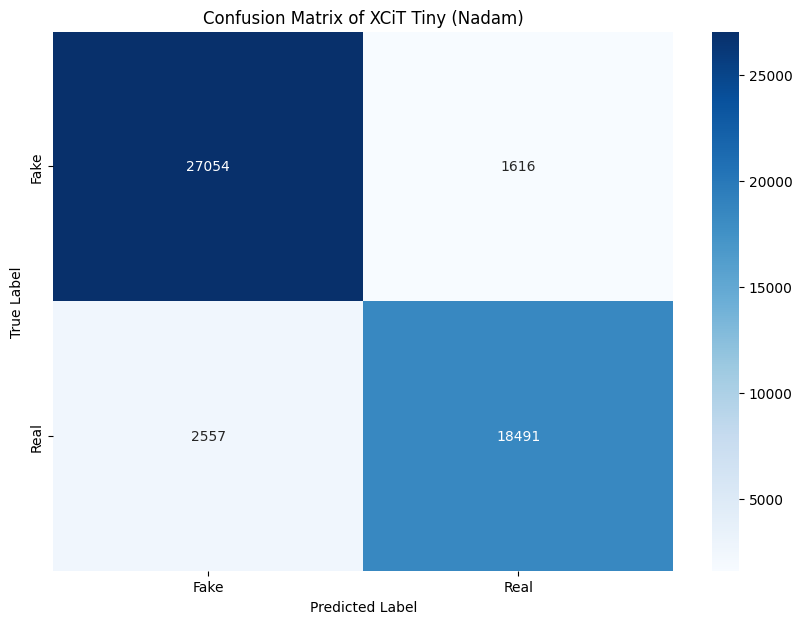

In [40]:
cm = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix of XCiT Tiny (Nadam)')
plt.show()

In [41]:
torch.save(xcit_model.state_dict(), 'xcit_tiny_patch16_224_5_epochs_balanced_nadam.pth')